# OASIS Brains Data Handling

We shall be using the `OASIS-1: Cross-sectional MRI Data in Young, Middle Aged, Nondemented and Demented Older Adults` dataset.

__Summary:__ This set consists of a cross-sectional collection of 416 subjects aged 18 to 96. For each subject, 3 or 4 individual T1-weighted MRI scans obtained in single scan sessions are included. The subjects are all right-handed and include both men and women. 100 of the included subjects over the age of 60 have been clinically diagnosed with very mild to moderate Alzheimer’s disease (AD). Additionally, a reliability data set is included containing 20 nondemented subjects imaged on a subsequent visit within 90 days of their initial session.

In [1]:
import os
import cv2 as cv
import numpy as np
import pandas as pd
import seaborn as sns
import nibabel as nib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Patient Metadata

First we shall handle the CSV file which contains the metadata for each of the patients.

In [2]:
oasis_dir = "/Data/OASIS"
meta_path = os.path.join(oasis_dir, "oasis_cross-sectional.csv")

df = pd.read_csv(meta_path)
df.head()

,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN


Check types are as expected.

In [3]:
df.dtypes

ID        object
M/F       object
Hand      object
Age        int64
Educ     float64
SES      float64
MMSE     float64
CDR      float64
eTIV       int64
nWBV     float64
ASF      float64
Delay    float64
dtype: object

### Missing values

Just inspecting the head of the dataframe above you can see there are some missing values. Lets see how many are missing from each feature.

In [4]:
print(f"Number of patients: {len(df)}")
df.isna().sum()

Number of patients: 436


ID         0
M/F        0
Hand       0
Age        0
Educ     201
SES      220
MMSE     201
CDR      201
eTIV       0
nWBV       0
ASF        0
Delay    416
dtype: int64

### Get AD subjects

We are particularly interested in the `CDR` column. This is the clinical dementia rating; a numeric scale used to quantify the severity of the symptoms of dementia determined by the patient's physician.

The scale is:

|CDR |Description |
|:-- |:--         |
|0   |No dementia | 
|0.5 |Very mild dementia | 
|1   |Mild dementia | 
|2   |Moderate dementia | 

We have 201 missing values from 436 patients (46%). This is a large percentage of the population, lets see how the remaining values are distributed across the possible ratings.

[(0.0, 135), (0.5, 70), (1.0, 28), (2.0, 2)]
/home/docker/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Number of Patients')

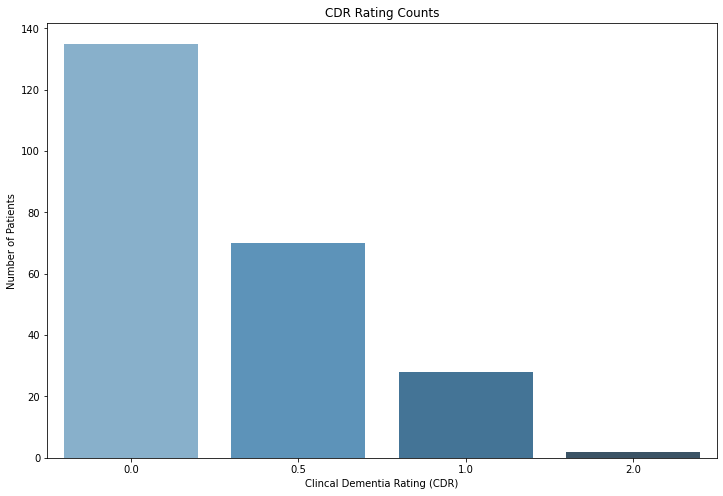

In [5]:
ratings = df["CDR"].dropna().sort_values().unique()
counts = df["CDR"].value_counts()

print([(rating, count) for (rating, count) in zip(ratings, counts)])

fig = plt.figure(figsize=(12,8))
sns.barplot(ratings, counts, palette="Blues_d")
plt.title("CDR Rating Counts")
plt.xlabel("Clincal Dementia Rating (CDR)")
plt.ylabel("Number of Patients")

We have a total of 235 patients with a given CDR, 135 (57%) of them being patients with no signs of dementia and 100 (43%) with. 

As we are interested in detecting patients with AD we shall create a binary label signifying a CDR greater than 0.

In [6]:
cdr_df = df.dropna(subset=["CDR"])[["ID", "CDR"]].copy()

cdr_df["AD"] = cdr_df["CDR"] > 0
cdr_df

,ID,CDR,AD
0,OAS1_0001_MR1,0.0,False
1,OAS1_0002_MR1,0.0,False
2,OAS1_0003_MR1,0.5,True
8,OAS1_0010_MR1,0.0,False
9,OAS1_0011_MR1,0.0,False
...,...,...,...
411,OAS1_0453_MR1,0.5,True
412,OAS1_0454_MR1,0.5,True
413,OAS1_0455_MR1,0.0,False
414,OAS1_0456_MR1,0.0,False


## Single MRI Slices

The OASIS contains MRI volumes of each patient. Also included are pre-processed slices and volumes, including grey-white matter segmentation masks. Grey and white matter astrophy is thought to be an indicator or Alzheimer's disease so it makes sense to try these segmented volumes as our training data. FSL_SEG directory includes the grey/white/CSF segmentation image generated from the masked atlas image.

In [7]:
data_dir = os.path.join(oasis_dir, "data")
subjects = cdr_df["ID"].tolist()

slice_paths = []
for subject in subjects:
    fsl_dir = os.path.join(data_dir, "{0}/FSL_SEG".format(subject))
    subject_slices = [os.path.join(fsl_dir,slice) for slice in os.listdir(fsl_dir) if slice[-4:] == ".gif"]
    slice_paths += subject_slices

print(f"found {len(slice_paths)} slices")

found 235 slices


Now we can load in the images.

In [8]:
slices = [plt.imread(path) for path in slice_paths]
print(f"loaded {len(slices)} slices")

loaded 235 slices


Lets visualise some of the images.

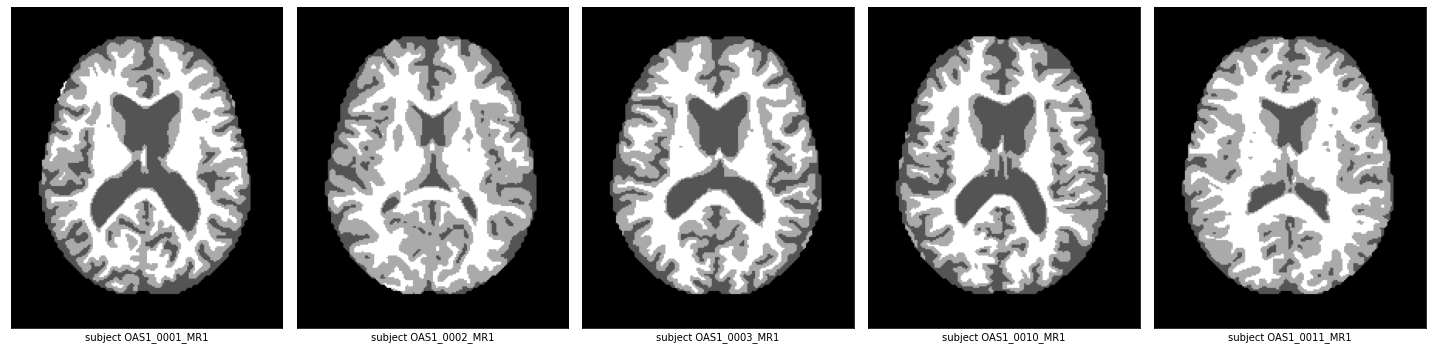

In [9]:
fig = plt.figure(figsize=(20,5))
for i, idx in enumerate(np.random.choice(len(slices), 5)):
    fig.add_subplot(1, 5, i+1)
    plt.imshow(slices[i], cmap="gray")
    plt.xlabel("subject {0}".format(subjects[i]))
    plt.xticks([])
    plt.yticks([])
fig.tight_layout()

### Create test and train sets

Now we have the images and their AD label we can create test and train sets.

First we shall replace the `AD` column with binary values.

In [10]:
ad_dict = {"AD": {False: 0, True: 1}}
labels = cdr_df.replace(ad_dict, inplace=False)["AD"].tolist()

We will create a smaller subset of the negative labels the same size as the positive labels to balance the dataset.

In [11]:
neg_idxs, pos_idxs = [], []
for i, label in enumerate(labels):
    if label == 0:
        neg_idxs.append(i)
    if label == 1:
        pos_idxs.append(i)

neg_idxs = np.random.choice(neg_idxs, len(pos_idxs))
target_idxs = np.append(neg_idxs, pos_idxs)
balanced_df = cdr_df.take(target_idxs)

X = np.take(slices, target_idxs, axis=0)
y = np.take(labels, target_idxs)

Now we can create the training sets.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10, stratify=y_train, random_state=42)

print(f"total:\t{len(X)}\ntrain:\t{len(X_train)}\nval:\t{len(X_val)}\ntest:\t{len(X_test)}")



total:	200
train:	180
val:	10
test:	10


## Save to project directory

Now we have the training sets we can save them to the project directory.

In [13]:
def getdirs(classes, subdir):
    data_dir = os.path.join(os.path.join(os.getcwd(), os.pardir), "resources/data/oasis/{0}".format(subdir))
    dir_sets = []
    for s in ["train", "val", "test"]:
        dirs = []
        for c in classes:
            dir = "{0}/{1}/".format(s, c)
            dirs.append(os.path.join(data_dir, dir))
        dir_sets.append(dirs)
    return dir_sets

def mkdirs(classes, subdir):
    dir_sets = getdirs(classes, subdir)
    for dirs in dir_sets:
        for dir in dirs:
            if not os.path.isdir(dir):    
                os.makedirs(dir)
            else:
                for filepath in os.listdir(dir):
                    os.remove(os.path.join(dir, filepath))
 
def write_imgs(classes, subdir, X_train, y_train, X_val, y_val, X_test, y_test):
    dir_sets = getdirs(classes, subdir)
    sets = [(X_train, y_train), (X_val, y_val), (X_test, y_test)]
    for (dirs, (X, y)) in zip(dir_sets, sets):
        counter = [0] * len(classes)
        for (img, label) in zip(X, y):
            filename = "{0}class_{1}_img_{2}.png".format(dirs[label], label, counter[label])
            cv.imwrite(filename, img)
            counter[label] += 1

classes = range(2)
subdir = "single/transverse/"
mkdirs(classes, subdir)
write_imgs(classes, subdir, X_train, y_train, X_val, y_val, X_test, y_test)

Check all images were written.

In [14]:
def check_imgs(classes, subdir):
    tsets = ["train", "val", "test"]
    counts = []
    for tset, ddirs in zip(tsets, getdirs(classes, subdir)):
        n_neg = len(os.listdir(ddirs[0]))
        n_pos = len(os.listdir(ddirs[1]))
        n_samples = n_neg + n_pos
        counts.append((tset, n_samples, n_neg, n_pos))
    total_samples, total_neg, total_pos = 0, 0, 0
    for tset, n_samples, n_neg, n_pos in counts:
        print(f"found {n_samples} images in {tset} set ({n_neg} negative, {n_pos} positive)")
        total_samples += n_samples
        total_neg += n_neg
        total_pos += n_pos

    print(f"\ntotal images found: {total_samples} ({total_neg} negative, {total_pos} positive)")

check_imgs(classes, "single/transverse")

found 180 images in train set (90 negative, 90 positive)
found 10 images in val set (5 negative, 5 positive)
found 10 images in test set (5 negative, 5 positive)

total images found: 200 (100 negative, 100 positive)


## Slicing MRIs

Due to the small size of the training set the model does not perform well. To give the model more information to learn from we shall create a training set consisting of many MRI slices.

Lets look at how we can slice the MRI volumes in each plane, transverse, coronal and sagital.

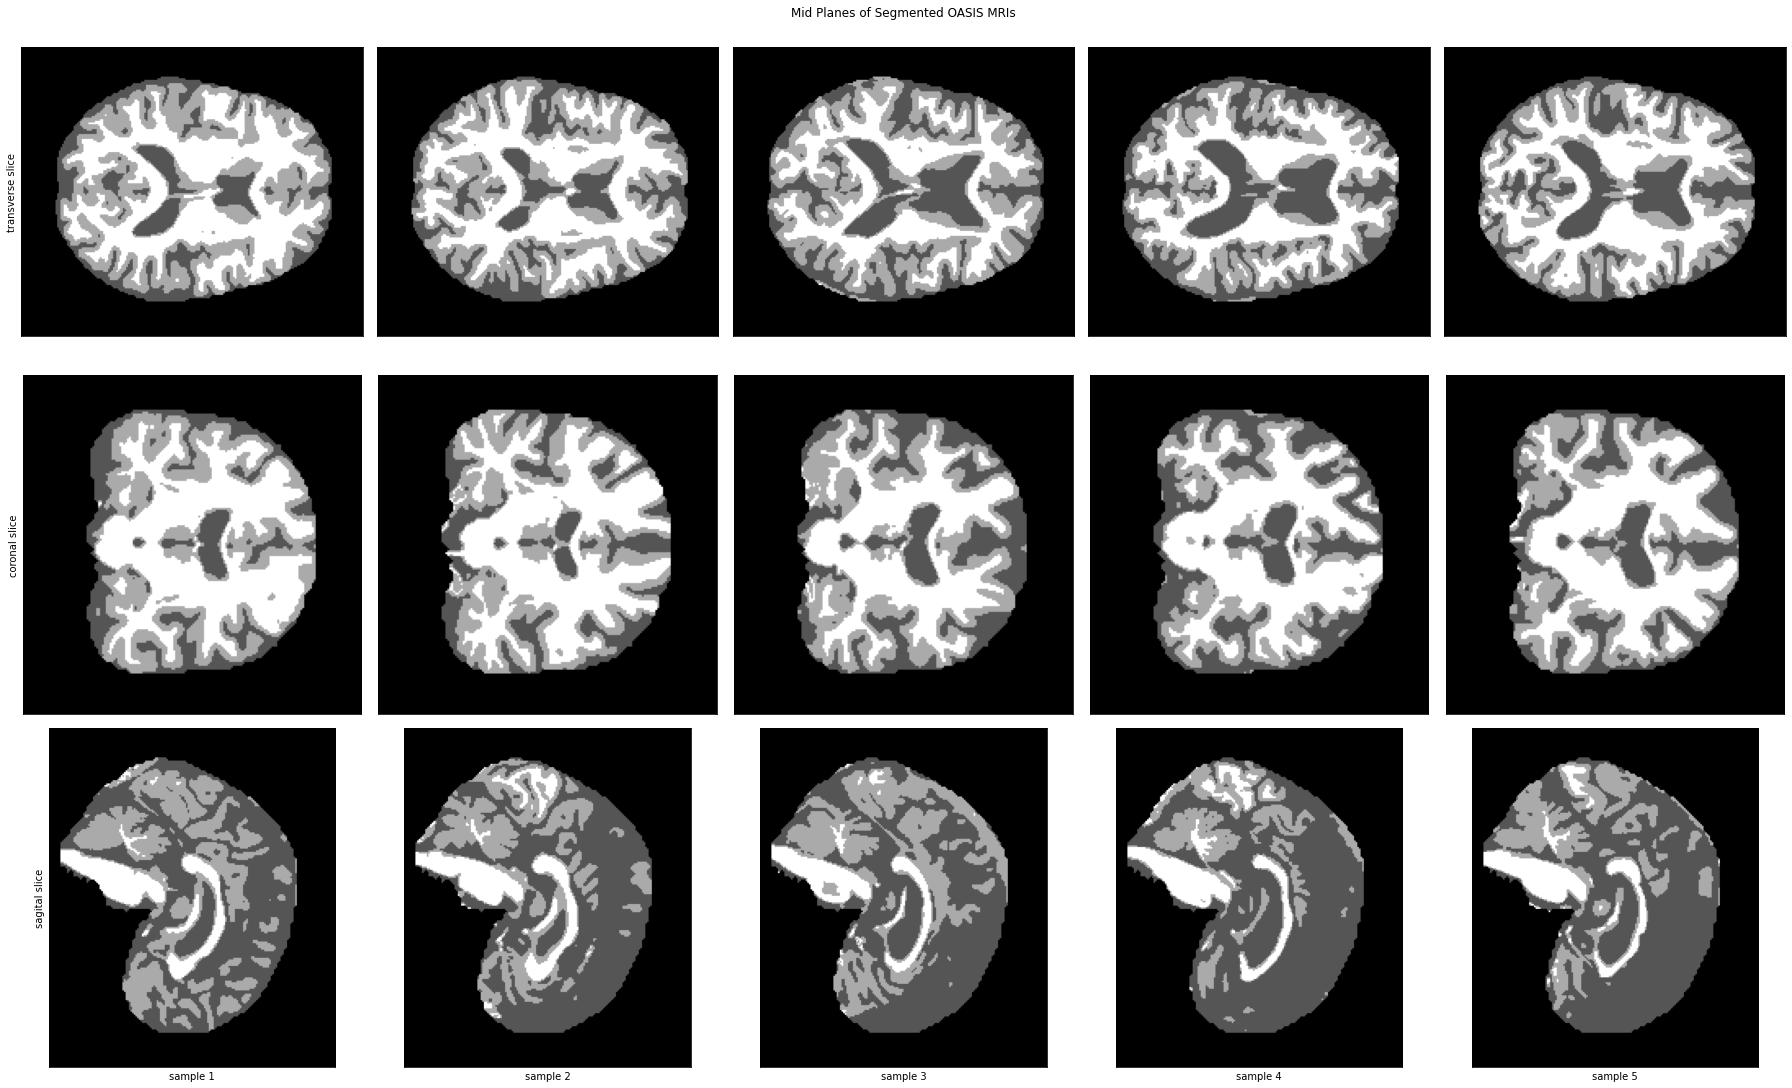

In [15]:
fsl_dirs = [os.path.join(data_dir, "{0}/FSL_SEG".format(subject)) for subject in subjects]

fig, ax = plt.subplots(figsize=(25, 15))
plt.title("Mid Planes of Segmented OASIS MRIs")
plt.xticks([])
plt.yticks([])
plt.box(None)
for i, idx in enumerate(np.random.choice(100, 5)):
    fsl_paths = [os.path.join(fsl_dirs[idx], name) for name in os.listdir(fsl_dirs[idx]) if name[-4:] == ".img"]
    nii = nib.load(fsl_paths[0])
    volume = nii.get_fdata()
    sagit_slice = ("sagital", volume[volume.shape[0] // 2, :, :])
    coron_slice = ("coronal", volume[:, volume.shape[1] // 2, :])
    trans_slice = ("transverse", volume[:, :, volume.shape[2] // 2])
    for j, (name, slice) in enumerate([trans_slice, coron_slice, sagit_slice]):
        ax = fig.add_subplot(3, 5, i+1+j*5)
        ax = plt.imshow(slice, cmap="gray")
        ax = plt.xticks([])
        ax = plt.yticks([])
        if i == 0:
            ax = plt.ylabel("{} slice".format(name))    
        if name == "sagital":
            ax = plt.xlabel("sample {}".format(i+1))
    fig.tight_layout()

### Coronal slicing

Alzheimer's disease is thought to most visually affect the medial temporal lobe (MTL). The MTL is best seen through the coronal plane so we shall create a training set from this plane rather than the previous transverse slices.

First lets gather a list of the `.img` files and plot coronal slices and different depths.

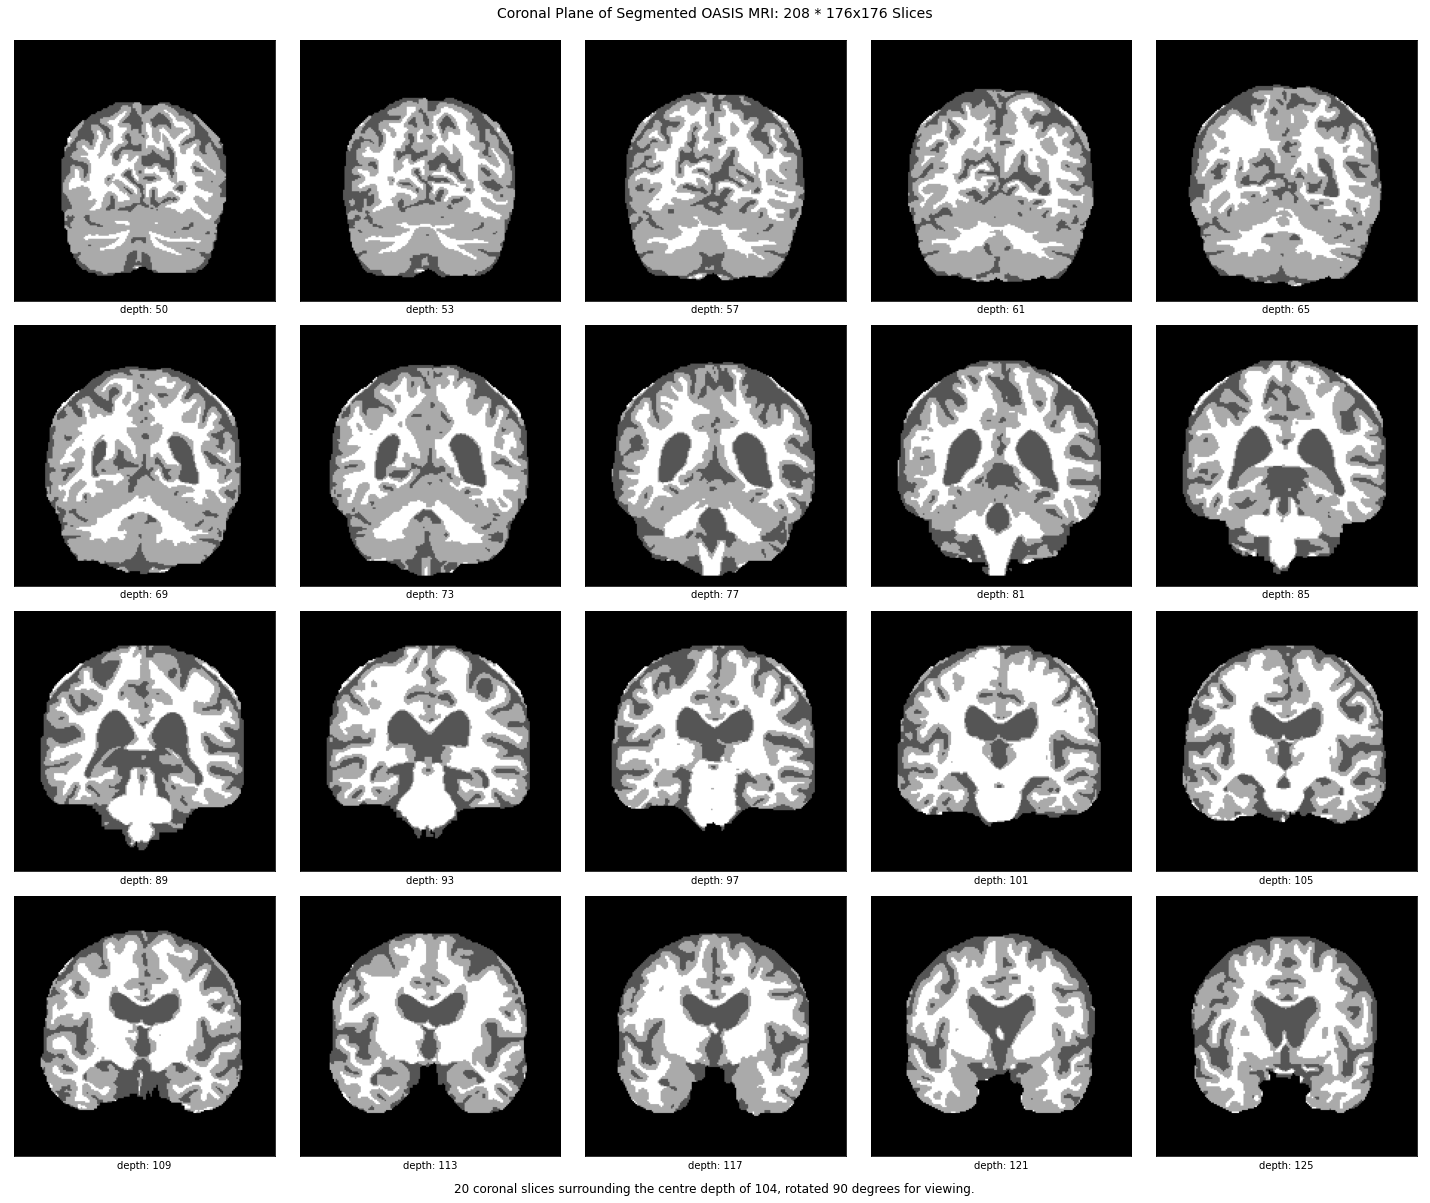

In [16]:
fsl_imgs = [[os.path.join(fsl_dir, fsl_path) for fsl_path in os.listdir(fsl_dir) if fsl_path[-4:] == ".img"][0] for fsl_dir in fsl_dirs]

nii = nib.load(fsl_imgs[0])
volume = nii.get_fdata()
n, rows = 20, 4
w, d, h, _ = volume.shape

fig, ax = plt.subplots(figsize=(20, 16))
plt.figtext(0.5, 1.01, "Coronal Plane of Segmented OASIS MRI: {0} * {1}x{2} Slices".format(d, w, h), ha="center", fontsize=14)
plt.xticks([])
plt.yticks([])
plt.box(None)
for i, depth in enumerate(np.linspace(50, 125, n).astype(int)):
    coron_slice = volume[:, depth, :]
    ax = fig.add_subplot(rows, n//rows, i+1)
    ax = plt.imshow(np.rot90(coron_slice), cmap="gray")
    ax = plt.xlabel("depth: {0}".format(depth))
    ax = plt.xticks([])
    ax = plt.yticks([])
plt.figtext(0.5, -0.01, "20 coronal slices surrounding the centre depth of 104, rotated 90 degrees for viewing.", ha="center", fontsize=12)
fig.tight_layout()

The medial temporal lobe is a brain region at the side of the brain around the centre point of the sagital plane. Given this it visible throughout a number of depths but initially we shall take the mid-depth 104 as this has reasonable coverage of the MTL.

We shall create a new set of coronal slices and save them to the project directory.

In [17]:
target_depth = 104

# make directories
classes = range(2)
subdir = "single/coronal/"
mkdirs(classes, subdir)
base_dir = os.path.join(os.getcwd(), os.pardir)

# get paths from subject names and binary labels from AD diagnosis
subjects = balanced_df["ID"].tolist()
X_subjects = [[os.path.join(fsl_dir, name) for name in os.listdir(fsl_dir) if name[-4:] == ".img"][0] for fsl_dir in [os.path.join(data_dir, "{0}/FSL_SEG".format(subject)) for subject in subjects]]
y = balanced_df.replace(ad_dict, inplace=False)["AD"].tolist()

# create train, val and test sets
X_train_subjects, X_test_subjects, y_train, y_test = train_test_split(X_subjects, y, test_size=10, stratify=y, random_state=42)
X_train_subjects, X_val_subjects, y_train, y_val = train_test_split(X_train_subjects, y_train, test_size=10, stratify=y_train, random_state=42)

# save to project
for X_paths, y, tset in [(X_train_subjects, y_train, "train"), (X_val_subjects, y_val, "val"), (X_test_subjects, y_test, "test")]:
    i0, i1 = 0, 0
    for X_path, label in zip(X_paths, y):
        # load and slice
        nii = nib.load(X_path)
        volume = nii.get_fdata()
        coron_slice = volume[:, target_depth, :]
        # get target slice path
        slice_name = "class_{0}_img_{1}.png".format(label, i1 if label else i0)
        project_dir = os.path.join(base_dir, "resources/data/oasis/single/coronal/{0}/{1}/".format(tset, label))
        project_path = os.path.join(project_dir, slice_name)
        # change segmentation values from 0-3 to 0-255
        cv.imwrite(project_path, coron_slice * 255.0 / 3.0)
        # increment counters
        if label:
            i1 += 1
        else:
            i0 += 1

Check all images were written.

In [18]:
check_imgs(classes, "single/coronal")

found 180 images in train set (90 negative, 90 positive)
found 10 images in val set (5 negative, 5 positive)
found 10 images in test set (5 negative, 5 positive)

total images found: 200 (100 negative, 100 positive)


### Multiple slices

To cover more of the MTL we shall extract a range of slices across the MTL.

As per [Scheltens, P. et al. Atrophy of medial temporal lobes on MRI in “probable” Alzheimer’s disease and normal ageing](https://jnnp.bmj.com/content/jnnp/55/10/967.full.pdf), I shall extract 6 MTL slices with a 1mm gap (single voxel) between each, i.e. 6 slices with a range of 12mm starting at the anterior pons.

The below plot shows the sagital plane of an MRI with a line plotted across the depth of the anterior pons. This is the first depth at which we will take a coronal slice, we will then slice further towards the prefrontal cortex.

Text(0.5, 0, 'Coronal Depth')

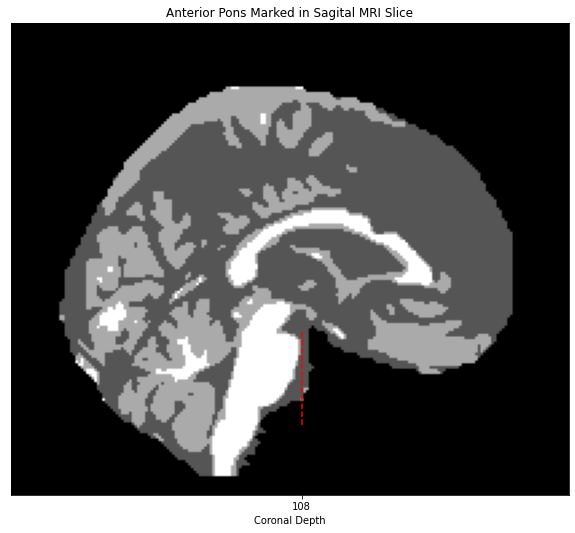

In [19]:
img = volume[volume.shape[0] // 2, :, :]
apons_depth = 108

plt.figure(figsize=(10,10))
plt.imshow(np.rot90(img), cmap="gray")
plt.title("Anterior Pons Marked in Sagital MRI Slice")
plt.plot((apons_depth, apons_depth), (115, 150), c="r", linestyle="dashed")
plt.xticks([apons_depth])
plt.yticks([])
plt.xlabel("Coronal Depth")

From the plot above we can see the antior pons is at a depth of `108` for this particular sample. As samples have all been normalised to a template we can expect the location of the anterior pons to be relatively similar between samples so we shall use 108 as the starting depth for all samples.

In [23]:
# make directories
subdir = "multi/coronal/"
mkdirs(classes, subdir)

# get paths from subject names and binary labels from AD diagnosis
subjects = balanced_df["ID"].tolist()
X_subjects = [[os.path.join(fsl_dir, name) for name in os.listdir(fsl_dir) if name[-4:] == ".img"][0] for fsl_dir in [os.path.join(data_dir, "{0}/FSL_SEG".format(subject)) for subject in subjects]]
y = balanced_df.replace(ad_dict, inplace=False)["AD"].tolist()
# create train, val and test sets
X_train_subjects, X_test_subjects, y_train, y_test = train_test_split(X_subjects, y, test_size=0.1, stratify=y, random_state=42)
X_train_subjects, X_val_subjects, y_train, y_val = train_test_split(X_train_subjects, y_train, test_size=0.1, stratify=y_train, random_state=42)

# save to project
for X_paths, y, tset in [(X_train_subjects, y_train, "train"), (X_val_subjects, y_val, "val"), (X_test_subjects, y_test, "test")]:
    i0, i1 = 0, 0
    for X_path, label in zip(X_paths, y):
        # load and get dir
        nii = nib.load(X_path)
        volume = nii.get_fdata()
        # project_dir = os.path.join(base_dir, "resources/data/oasis/single/coronal/{0}/{1}/".format(tset, label))
        project_dir = os.path.join(base_dir, "resources/data/oasis/multi/coronal/{0}/{1}".format(tset, label))
        # for each slice
        for depth in np.arange(apons_depth, apons_depth+12, step=2):
            # slice
            coron_slice = volume[:, depth, :]
            # get target slice path
            slice_name = "class_{0}_img_{1}_depth_{2}.png".format(label, i1 if label else i0, depth)
            project_path = os.path.join(project_dir, slice_name)
            # change segmentation values from 0-3 to 0-255
            cv.imwrite(project_path, coron_slice * 255.0 / 3.0)
        # increment counters
        if label:
            i1 += 1
        else:
            i0 += 1